In [443]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device", jax.devices()[2])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel,build_batched_jac_func
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import SketchedCG_LM

import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 12
})

## 1.5 Step method

In [425]:
# Sample m training functions as initial conditions from a GP
def get_burgers_data(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
                            
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plot_input_data(
        tx_obs,
        tx_all,
        u_true_function,
        tx_fine,
                )

    return tx_obs, u_obs, tx_all, tx_fine, u_true_function, ut_true_function, ux_true_function, uxx_true_function

  0%|          | 0/10099 [00:00<?, ?it/s]

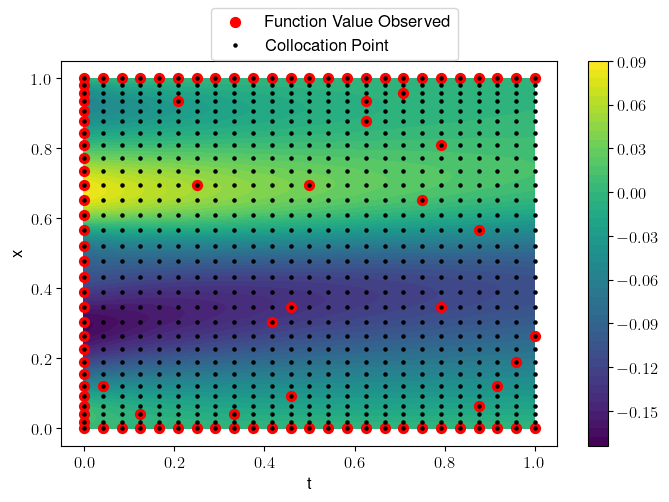

In [426]:
tx_obs, u_obs, tx_all, tx_fine, u_true_function, ut_true_function, ux_true_function, uxx_true_function = get_burgers_data(gamma=2,n_obs=20,n_coll_t=25, n_coll_x=30, run = 2)

In [427]:
# Run 1_5 step method
u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,1.])))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
    .reshape(
            len(tx_all),
            len(feature_operators),
            order = 'F'
        )
)

# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = OperatorModel(k_P)

[0.98971991 0.14241001]


In [428]:
# Equation model that has u and P object
EqnModel = SplitOperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100,
    jacobian_operator = build_batched_jac_func(100),
)

In [429]:
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
spcg_params,cg_convergence_data = SketchedCG_LM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    max_iter = 501,
    init_alpha=0.1,
    print_every = 100,
    sketch_size = 200,
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.02837, Jres = 3.519, alpha = 0.08333, improvement_ratio = 0.9526
Iteration 1, loss = 0.02799, Jres = 1.075, alpha = 0.06944, improvement_ratio = 0.917
Iteration 2, loss = 0.02779, Jres = 1.706, alpha = 0.05787, improvement_ratio = 0.9785
Iteration 3, loss = 0.02769, Jres = 0.4505, alpha = 0.04823, improvement_ratio = 0.9755
Iteration 4, loss = 0.02761, Jres = 0.2292, alpha = 0.04019, improvement_ratio = 0.9741
Iteration 5, loss = 0.02755, Jres = 0.2207, alpha = 0.03349, improvement_ratio = 0.9589
Iteration 100, loss = 0.0138, Jres = 3.572, alpha = 6.036e-05, improvement_ratio = 0.6954
Iteration 200, loss = 0.004983, Jres = 47.83, alpha = 7.283e-05, improvement_ratio = 0.4568
Iteration 300, loss = 0.003902, Jres = 34.95, alpha = 3.327e-05, improvement_ratio = 0.6139
Iteration 400, loss = 0.003492, Jres = 38.99, alpha = 4.181e-05, improvement_ratio = 0.9326
Iteration 500, loss = 0.003221, Jres = 13.23, alpha = 3.875e-05, improvement_ratio = 0.4179


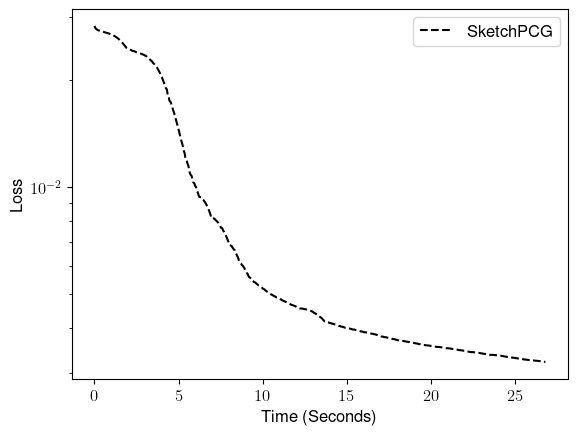

In [430]:
plt.plot(
    jnp.array(cg_convergence_data['time_spent']) - jnp.array(cg_convergence_data['time_spent'])[0],
    jnp.array(cg_convergence_data['loss_vals'])[1:],
    label = 'SketchPCG',
    c='black',
    ls = '--')

plt.yscale('log')
plt.legend()
plt.xlabel("Time (Seconds)")
# plt.plot([0,150],[5e-7,5e-7])
plt.ylabel("Loss")
plt.show()

In [431]:
# u_params
u_sol = spcg_params[:u_model.num_params]
P_sol = spcg_params[u_model.num_params:]
# u_true 
u_true = u_true_function(tx_fine)
# get error
error_u_field = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
error_u_field

Array(0.15228706, dtype=float64)

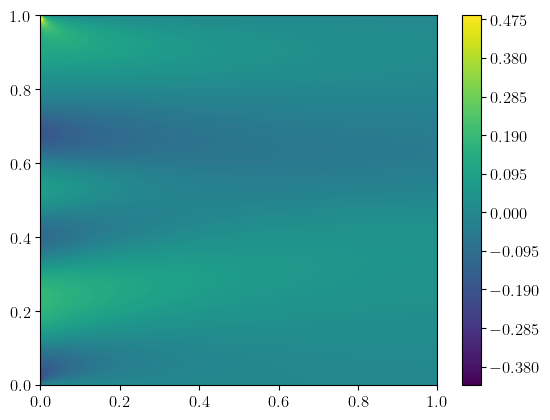

In [432]:
plt.tricontourf(*tx_fine.T,ut_true_function(tx_fine),200)
plt.colorbar()
plt.show()

In [433]:
# Estimated P from 1.5 step method
input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all) # now
Phat = lambda x: P_model.predict_new(x,input_features,P_sol)

# In-sample

# P[\phi(w)](fine_grid)
def evaluate_Phat(Phat, interp, fine_grid):

    # Build S_test
    def u_true_function(x):
        return interp(x[:,0],x[:,1],grid = False)
    def ux_true_function(x):
        ux_interp = interp.partial_derivative(0,1)
        return ux_interp(x[:,0],x[:,1],grid = False)
    def uxx_true_function(x):
        uxx_interp = interp.partial_derivative(0,2)
        return uxx_interp(x[:,0],x[:,1],grid = False)
    
    # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
    feat_funcs = [u_true_function, ux_true_function, uxx_true_function]
    w_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
    print(w_features.shape)
    fine_features = jnp.hstack([fine_grid, w_features])
    S_test = fine_features
    
    P_preds = Phat(S_test)
    return P_preds, S_test

In [434]:
t_test,x_test = jnp.meshgrid(jnp.linspace(0.1,0.9,30),jnp.linspace(0.1,0.9,30))
tx_test = jnp.vstack([t_test.flatten(),x_test.flatten()]).T

In [435]:
Phat_u, S_test = evaluate_Phat(Phat, interp, tx_test)
u_t = ut_true_function(tx_test)

(900, 3)


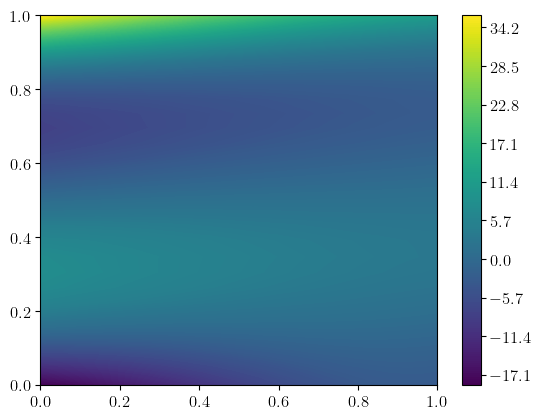

In [436]:
plt.tricontourf(*tx_all.T, model_grid_features_all[:,4],200)
plt.colorbar()

Relative error:  0.5352252734584033


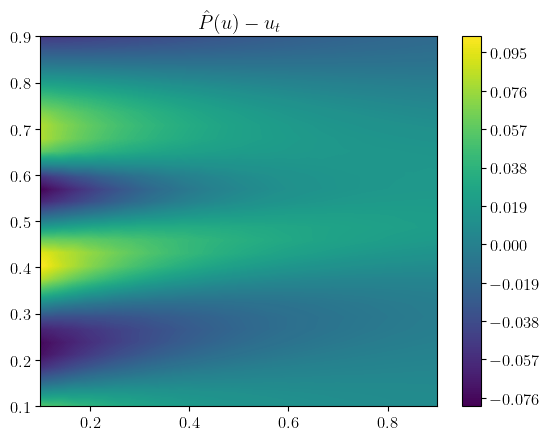

In [437]:
# plt.tricontourf(*tx_test.T, (Phat_u - u_t)/ jnp.linalg.norm(u_t),200)
# plt.title(r'$\frac{1}{\|u_t\|}(\hat{P}(u)-u_t)$')
plt.tricontourf(*tx_test.T, (Phat_u - u_t),200)
plt.colorbar()
print('Relative error: ',jnp.linalg.norm(Phat_u - u_t,2) / jnp.linalg.norm(u_t,2))
plt.title(r'$\hat{P}(u)-u_t$')
plt.show()

## PINNSR

In [444]:
def get_data_for_pinns(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
                            
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plot_input_data(
        tx_obs,
        tx_all,
        u_true_function,
        tx_fine,
                )
    
    # Invert them to be ready for PINNSR
    
    tx_train = tx_obs
    u_train = u_true_function(tx_train)
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (20,), replace=False)
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)

    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    return [tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

  0%|          | 0/10099 [00:00<?, ?it/s]

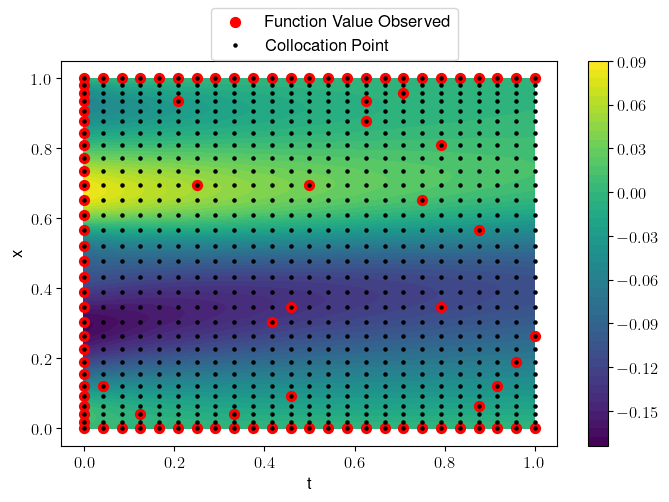

In [445]:
data_pinns = get_data_for_pinns(gamma=2,n_obs=20,n_coll_t=25, n_coll_x=30, run = 2)

In [449]:
data_numpy = list(map(np.array,data_pinns))

In [467]:
np.save('data_test_pinn.npy', np.array(data_numpy, dtype=object), allow_pickle=True)

The equation recovered by PINNSR was:
```
u_t = -0.0098339461-0.28679112u-0.0530404u_x+0.005522664u_xx
```

In [476]:
# Estimated P
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)
def ux_true_function(x):
    ux_interp = interp.partial_derivative(0,1)
    return ux_interp(x[:,0],x[:,1],grid = False)
def uxx_true_function(x):
    uxx_interp = interp.partial_derivative(0,2)
    return uxx_interp(x[:,0],x[:,1],grid = False)

fine_grid = tx_test
U = u_true_function(fine_grid)
U_x = ux_true_function(fine_grid)
U_xx = uxx_true_function(fine_grid)

Phat_PINNSR = -0.0098339461-0.28679112*U-0.0530404*U_x+0.005522664*U_xx

Relative error:  0.38548803069017246


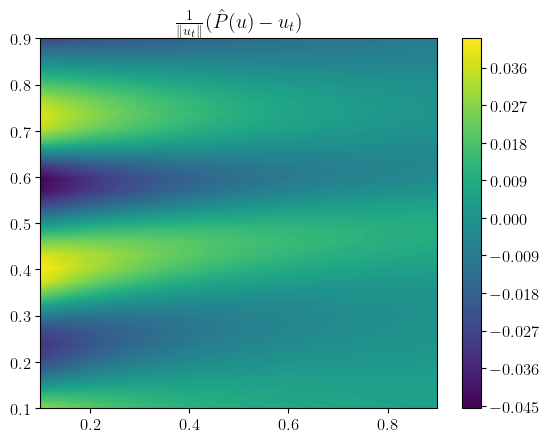

In [482]:
plt.tricontourf(*tx_test.T, (Phat_PINNSR - u_t)/ jnp.linalg.norm(u_t),200)
plt.title(r'$\frac{1}{\|u_t\|}(\hat{P}(u)-u_t)$')
# plt.tricontourf(*tx_test.T, (Phat_PINNSR - u_t),200)
plt.colorbar()
print('Relative error: ',jnp.linalg.norm(Phat_PINNSR - u_t,2) / jnp.linalg.norm(u_t,2))
# plt.title(r'$\hat{P}(u)-u_t$')
plt.show()